#### Structure of the document

##### 1. Import of experimental data
##### 2. Preprocessing of the data

First of all, the timestamp is transformed into the datetime format to be able to do 'time calcualtions' with it. This is important because each dataframe has its unique timestamp with varying sample frequencies. Therefore, a overall sample frequency of 1min is chosen for each dataframe which simplifies the alignment of the data. Within that step we need to decide how we handle the excessive data because usually we have multiple measurements in one minute. The parameters **Pump Acid Value** and **Pump Base Value** contain the information how much of each is fed to the system. Looking at all the data points that we have for one minute, we don't want to neglect any data of how much is going into the system. Consequently, we sum all feeds, divide it by the feeding duration, convert it into L/min and assigned that value to this minute. For the other parameters such as **Temperature**, **Stirring**, **Glucose feed**, **dissolved $O_2$**, **pH** and **Air flow**, this procedure doesn't make sense. Those parameters are continuously measured. The mean value is calculated and assigned to its minute. Be aware that this data treatment is a smoothing factor.

##### 3. Calculations of new parameters

- Conversion into suitable units
- Outlier removal for glucose feed
- Calculation of volume, OUR, CER and RQ

##### 4. Saving the new dataframe as .csv file (data_combined.csv)
##### 5. Visualization

#### Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

pd.options.mode.chained_assignment = None  # Suppress the warning

##### 1. Import experimental data

Temperature / Stirring / Feed of Glucose / Base & Acid / dissolved $O_2$ / pH / Air feed / Offgas analysis / Biomass / HPLC measurements

In [2]:
df_T=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Temperature_Value.csv', sep=';')
df_stir=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Stirrer_Value.csv', sep=';')
df_feed1=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Feed 1_Value.csv', sep=';')
df_base=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Base_Value.csv', sep=';')
df_acid=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Acid_Value.csv', sep=';')
df_pO2=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pO₂_Value.csv', sep=';')
df_pH=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pH_Value.csv', sep=';')
df_air=pd.read_csv('data/fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Flow - Air_Value.csv', sep=';')
df_offgas=pd.read_excel('data/fermentation raw data/offgas_data.xlsx')
df_biomass=pd.read_csv('data/fermentation raw data/biomass_OD.csv', sep=';')
df_hplc = pd.read_csv('data/fermentation raw data/HPLC.csv', sep=';')

##### 2. Data Preprocessing

In [3]:
# group the dataframes -- acid and base will be pre-processed differently
first_para=[df_T, df_stir, df_feed1, df_pO2, df_pH, df_air]
second_para=[df_base, df_acid]

In [4]:
start = '31-05-2023 10:14:00'
end = '02-06-2023 08:22:00'
start_time = datetime.strptime(start, '%d-%m-%Y %H:%M:%S')
end_time = datetime.strptime(end, '%d-%m-%Y %H:%M:%S')

First parameter group (mean value for reduction of sampling frequency):

In [5]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
df_merged1=pd.DataFrame()
for df in first_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').mean() # could be changed to sum/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged1.empty:
        df_merged1=df_se
    else:
        df_merged1=df_merged1.merge(df_se, on='DateTime', how='inner')

Second parameter group (sum for reduction of sampling frequency):

In [6]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
# since the feed of base/acid lasts only 5s, data will be lost if we take the first value
## instead we take the sum of the values within that minute and then later divide it by (5/60)
df_merged2=pd.DataFrame()
for df in second_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').sum() # could be changed to sum/mean/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged2.empty:
        df_merged2=df_se
    else:
        df_merged2=df_merged2.merge(df_se, on='DateTime', how='inner')

In [7]:
# merging the 2 dataframes
df_merged3 = df_merged1.copy()
df_merged3 = df_merged3.merge(df_merged2, on='DateTime', how='inner')

Merge offgas to the other parameters.

In [8]:
# offgas values are saved in another dataframe
## same preprocessing as the others

# methanol is zero for the whole time period and RMS is not needed
## ethanol has 30 not zero values but the highest is 0.0001 %
df_offgas.drop(['offg_ethanol', 'offg_methanol', 'offg_RMS'], axis=1, inplace=True) #
# reduce sample frequency to 1min which makes the merge easier
## mean value of each minute is taken
df_offgas.set_index('Timestamp', inplace=True)
df_resampled = df_offgas.resample('1T').mean() # could be changed to sum/mean/first/min/max...
df_resampled.reset_index(drop=False, inplace=True)
df_resampled.rename(columns={'Timestamp': 'DateTime'}, inplace=True)

# dataframe is reduced to the start and end time of the fermentation
df_offg=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]

## checking if sum of measurements is equal to 100
# df_offg['sum']=df_offg[['offg_co2', 'offg_n2', 'offg_o2']].sum(axis=1)
# df_offg['y_CO2']=df_offg['offg_co2']/df_offg['sum']
# df_offg['y_O2']=df_offg['offg_co2']/df_offg['sum']
# df_offg['y_N2']=df_offg['offg_co2']/df_offg['sum']

In [9]:
# add process duration in hours as time [h]
df_merged4=df_merged3.merge(df_offg, on='DateTime', how='inner')
first_timestamp = df_merged4['DateTime'].iloc[0]  # Get the first timestamp
df_merged4['time [h]'] = (df_merged4['DateTime'] - first_timestamp) / pd.Timedelta(hours=1)
df_merged4['time [h]'] = df_merged4['time [h]'].round(2)
df_merged4.rename(columns={'Temperature Value (°C)': 'Temperature [°C]', 'Stirrer Value (rpm)': 'Stirrer [rpm]', 'pO₂ Value (pO₂)': 'DO2 [%]'}, errors='raise', inplace=True)
df_merged4.rename(columns={'offg_co2': 'Offgas CO2 [%]', 'offg_n2': 'Offgas N2 [%]', 'offg_o2': 'Offgas O2 [%]'}, errors='raise', inplace=True)
df_merged4.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],time [h]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.0225,1.0,0.0,0.0,0.03907,77.497645,21.178897,0.0


Merge biomass to the other parameters.

In [10]:
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.rename(columns={'hours': 'time [h]', 'biomass (g/L)': 'Biomass [g/L]'}, inplace=True)
df_biomass.head(1)

,Biomass [g/L],time [h]
0,0.694,0.2


Merge HPLC data for glucose, lactic acid, acetic acid and ehtanol to other paramters.

In [11]:
for col in df_hplc.columns:
     df_hplc[col] = df_hplc[col].str.replace(',', '.')
     df_hplc[col] = pd.to_numeric(df_hplc[col])
df_hplc.rename(columns={'Time [h]': 'time [h]'}, inplace=True)
# the hplc measurements were diluted with XXX in a 1:1 ratio
## therefore all values have to be multiplied by 2
df_hplc.iloc[:, 1:5] *= 2
df_hplc.head(1)

,time [h],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L]
0,0.2,10.44,0.34,0.08,0.02,0.08


In [12]:
# merging the biomass data with the hplc data
df_Yxs = df_biomass.merge(df_hplc, on='time [h]', how='left')

# Save the DataFrame to an Excel file
df_Yxs.to_excel('data/Yxs_table.xlsx', index=False)
df_Yxs.head(1)

,Biomass [g/L],time [h],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L]
0,0.694,0.2,10.44,0.34,0.08,0.02,0.08


In [13]:
# merging the biomass, substrates and coefficients to the overall dataframe
df = df_merged4.merge(df_Yxs, on='time [h]', how='left')
df.head(3)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],time [h],Biomass [g/L],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.02250,1.0,0.0,0.0,0.039070,77.497645,21.178897,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-31 10:16:00,29.863333,293.145833,0.0,65.328750,7.02000,1.0,0.0,0.0,0.039194,77.495783,21.178618,0.02,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-05-31 10:17:00,29.827500,293.525833,0.0,58.371111,7.01125,1.0,0.0,0.0,0.039268,77.510640,21.174856,0.03,NaN,NaN,NaN,NaN,NaN,NaN


##### 3. Calculation of process parameters

Final dataframe created. Now, adding parameters:

In [14]:
# the peak around the 7th hour was not fed into the batch but just to accumulate the glucose in the pipe
df.loc[df.index[428:431], 'Feed 1 Value (%)'] = 0

# after 34 h the Glucose feed was most likely empty but it was still measured as feeding
df.loc[df['time [h]'] > 34, 'Feed 1 Value (%)'] = 0
df['Feed 1 Value (%)']=df['Feed 1 Value (%)']/(10*1000)
df.rename(columns={'Feed 1 Value (%)': 'Glucose feed [L/min]'}, inplace=True)

In [15]:
# one feed of base/acid lasts for max 5s. Since we have samples every minute I divided the value of the feed rate by 12 because I multiply by 5s*1/60s
df['Pump - Base Value (%)']=df['Pump - Base Value (%)']/(12*10*1000)
df['Pump - Acid Value (%)']=df['Pump - Acid Value (%)']/(12*10*1000)
df.rename(columns={'Pump - Base Value (%)': 'Pump - Base [L/min]', 'Pump - Acid Value (%)': 'Pump - Acid [L/min]', 'Flow - Air Value': 'Air feed [mL/min]'}, inplace=True)

# Cumulative Base Feed
df['Cum. Base feed [L/min]']=df['Pump - Base [L/min]'].cumsum()
df['Cum. Acid feed [L/min]']=df['Pump - Acid [L/min]'].cumsum()

df['Air feed [mL/min]']=df['Air feed [mL/min]']/(10)

In [16]:
df['Offgas CO2 [mL/min]']=df['Air feed [mL/min]'] * df['Offgas CO2 [%]']/100
df['Offgas O2 [mL/min]']=df['Air feed [mL/min]'] * df['Offgas O2 [%]']/100
df['Offgas N2 [mL/min]']=df['Air feed [mL/min]'] * df['Offgas N2 [%]']/100

Volume calculation is missing evaporation term - since no weight measurements, it is not included so far (no way to check if it is correct)

In [17]:
# since the fermentation is fed-batch, the volume increases with time but sampling reduces the volume
## in total 400 mL were taken out by sampling
## in order to make it a continuous reduction it is divided by the total number of timestemps
df['Feed total [L/min]']=df['Glucose feed [L/min]']+df['Pump - Base [L/min]']+df['Pump - Acid [L/min]'] - 0.4/2767
df['Volume [L]']=df['Feed total [L/min]'].cumsum().add(1)

# # carolines euqation, question mark is just the concentration of water that goes in (last term)
# df['F_evap [kg/h]'] = (df['Air feed [mL/min]']*60/100)*(0.0235*3294) - 0.65

# Feed 1 contains 350 g/L glucose so a new parameter with the feed rate in g/h is added
df['Glucose feed [g/h]']=df['Glucose feed [L/min]']*350*60

# dissolved oxygen, stirring and the temperature fluctuate a lot so exponential smooting is applied
df['DO2 [%]- smoothed']=df['DO2 [%]'].ewm(alpha=0.1).mean()
df['Stirring [rpm]- smoothed']=df['Stirrer [rpm]'].ewm(alpha=0.1).mean()
df['T [°C]- smoothed']=df['Temperature [°C]'].ewm(alpha=0.1).mean()

In [18]:
df['OUR [%/L/h]'] = ((df['Offgas O2 [%]']-df['Offgas O2 [%]'][0])/df['Volume [L]'])/(df['time [h]'])
df['CER [%/L/h]'] = ((df['Offgas CO2 [%]']-df['Offgas CO2 [%]'][0])/df['Volume [L]'])/(df['time [h]'])
df['RQ'] = df['CER [%/L/h]'] / df['OUR [%/L/h]']*(-1)
df.head()

,DateTime,Temperature [°C],Stirrer [rpm],Glucose feed [L/min],DO2 [%],pH Value (pH),Air feed [mL/min],Pump - Base [L/min],Pump - Acid [L/min],Offgas CO2 [%],...,Offgas N2 [mL/min],Feed total [L/min],Volume [L],Glucose feed [g/h],DO2 [%]- smoothed,Stirring [rpm]- smoothed,T [°C]- smoothed,OUR [%/L/h],CER [%/L/h],RQ
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.02250,0.1,0.0,0.0,0.039070,...,0.077498,-0.000145,0.999855,0.0,72.283333,293.464167,29.869167,NaN,NaN,NaN
1,2023-05-31 10:16:00,29.863333,293.145833,0.0,65.328750,7.02000,0.1,0.0,0.0,0.039194,...,0.077496,-0.000145,0.999711,0.0,68.623026,293.296623,29.866096,-0.013960,0.006206,0.444548
2,2023-05-31 10:17:00,29.827500,293.525833,0.0,58.371111,7.01125,0.1,0.0,0.0,0.039268,...,0.077511,-0.000145,0.999566,0.0,64.840032,293.381202,29.851854,-0.134778,0.006607,0.049023
3,2023-05-31 10:18:00,29.762727,293.107273,0.0,51.463750,7.01000,0.1,0.0,0.0,0.039736,...,0.077513,-0.000145,0.999422,0.0,60.950447,293.301548,29.825938,-0.135629,0.013330,0.098284
4,2023-05-31 10:19:00,29.820833,292.355000,0.0,52.295556,7.00500,0.1,0.0,0.0,0.041027,...,0.077511,-0.000145,0.999277,0.0,58.836972,293.070407,29.824691,-0.079263,0.027973,0.352917


In [19]:
# the total volume in the end of the fermentation is compared with the experimental data
df['Volume [L]'].max()

2.5870542727272703

In [20]:
df.sort_index(axis=1, inplace=True)

##### 4. Save dataframe as .csv file

In [21]:
# save dataframe as csv and xlsx files
df.to_csv('data/data_combined.csv')
df.to_excel('data/data_combined.xlsx')

##### 5. Visualization

In [22]:
df.columns

Index(['Acetic acid [g/L]', 'Air feed [mL/min]', 'Biomass [g/L]',
       'CER [%/L/h]', 'Cum. Acid feed [L/min]', 'Cum. Base feed [L/min]',
       'DO2 [%]', 'DO2 [%]- smoothed', 'DateTime', 'Ethanol [g/L]',
       'Feed total [L/min]', 'Glucose [g/L]', 'Glucose feed [L/min]',
       'Glucose feed [g/h]', 'Glycerol [g/L]', 'Lactic acid [g/L]',
       'OUR [%/L/h]', 'Offgas CO2 [%]', 'Offgas CO2 [mL/min]', 'Offgas N2 [%]',
       'Offgas N2 [mL/min]', 'Offgas O2 [%]', 'Offgas O2 [mL/min]',
       'Pump - Acid [L/min]', 'Pump - Base [L/min]', 'RQ', 'Stirrer [rpm]',
       'Stirring [rpm]- smoothed', 'T [°C]- smoothed', 'Temperature [°C]',
       'Volume [L]', 'pH Value (pH)', 'time [h]'],
      dtype='object')

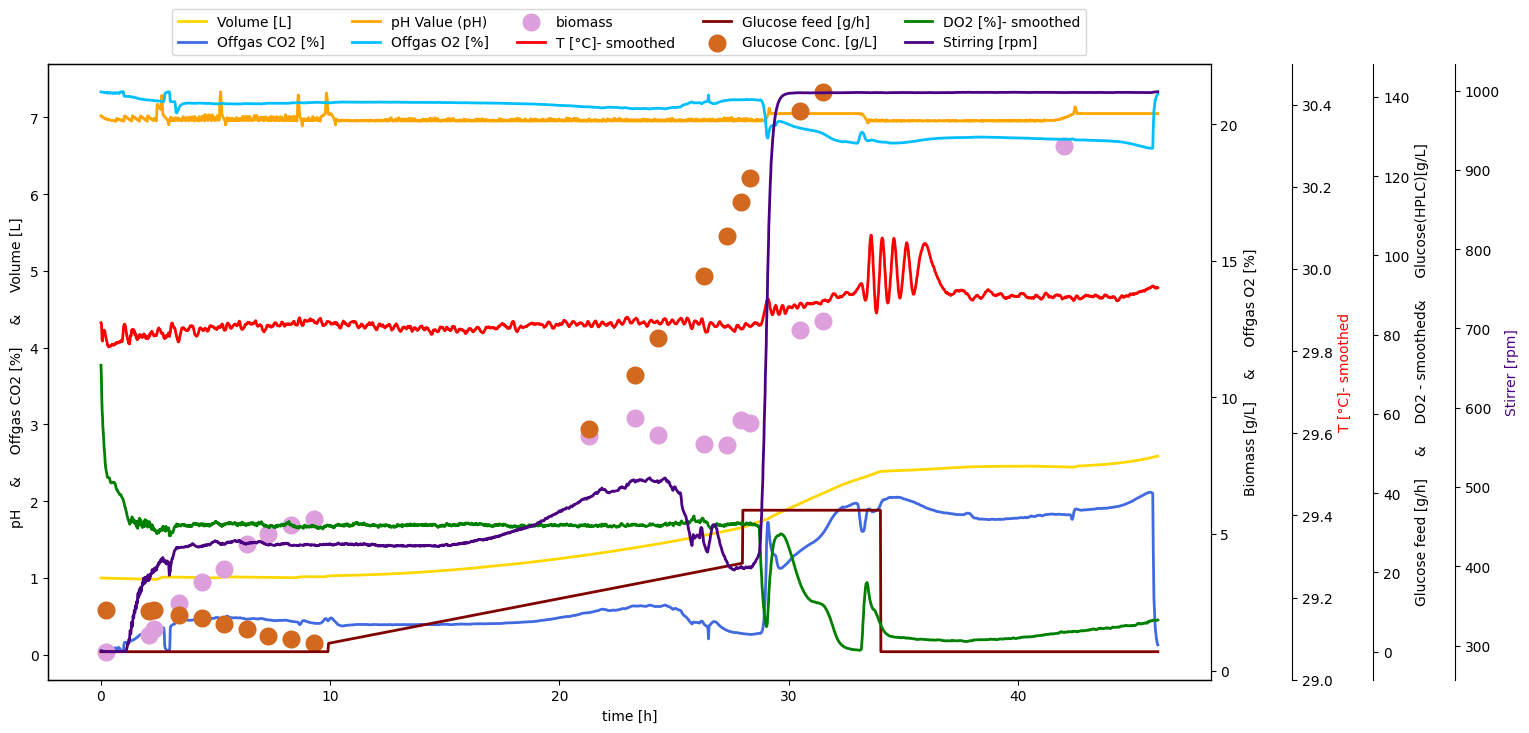

In [23]:
fig, ax = plt.subplots(1,1,figsize=(15,8))

ax_2nd=ax.twinx()
ax_3rd=ax.twinx()
ax_4th=ax.twinx()
ax_5th=ax.twinx()

ax_5th.plot(df['time [h]'], df['Stirring [rpm]- smoothed'], label='Stirring [rpm]', color='indigo', linewidth=2)
ax_4th.plot(df['time [h]'], df['Glucose feed [g/h]'], label='Glucose feed [g/h]', color='maroon', linewidth=2)
ax_4th.scatter(df['time [h]'], df['Glucose [g/L]'], label='Glucose Conc. [g/L]', linewidth=7, color='chocolate')
ax_4th.plot(df['time [h]'], df['DO2 [%]- smoothed'], label='DO2 [%]- smoothed', color='green', linewidth=2)
ax_3rd.plot(df['time [h]'], df['T [°C]- smoothed'], label='T [°C]- smoothed', color='red', linewidth=2)
ax_3rd.set_ylim(29,30.5)
ax_2nd.plot(df['time [h]'], df['Offgas O2 [%]'], label='Offgas O2 [%]', color='deepskyblue', linewidth=2)
ax.plot(df['time [h]'], df['Volume [L]'], label='Volume [L]', color='gold', linewidth=2)
ax.plot(df['time [h]'], df['Offgas CO2 [%]'], label='Offgas CO2 [%]', color='royalblue', linewidth=2)
ax.plot(df['time [h]'], df['pH Value (pH)'], label='pH Value (pH)', color='orange', linewidth=2)
#ax.plot(df['time [h]'], df['Air feed [mL/min]'], label='Flow - Air Value', color='aqua', linewidth=2)
ax_2nd.scatter(df['time [h]'], df['Biomass [g/L]'], linewidth=7, color='plum', label='biomass')

ax_3rd.spines.right.set_position(("axes", 1.07))
ax_4th.spines.right.set_position(("axes", 1.14))
ax_5th.spines.right.set_position(("axes", 1.21))

ax.set_xlabel('time [h]')
ax.set_ylabel('pH     &     Offgas CO2 [%]     &     Volume [L]') #     Flow - Air     &, color='orange'
ax_2nd.set_ylabel('Biomass [g/L]     &     Offgas O2 [%]') #, color='royalblue'
ax_3rd.set_ylabel('T [°C]- smoothed', color='red')
ax_4th.set_ylabel('Glucose feed [g/h]     &     DO2 - smoothed&     Glucose(HPLC)[g/L] ') #, color='green'
ax_5th.set_ylabel('Stirrer [rpm]', color='indigo')

# Get the handles and labels from all the axes
handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_2nd.get_legend_handles_labels()
handles_3rd, labels_3rd = ax_3rd.get_legend_handles_labels()
handles_4th, labels_4th = ax_4th.get_legend_handles_labels()
handles_5th, labels_5th = ax_5th.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd + handles_3rd + handles_4th + handles_5th
all_labels = labels + labels_2nd + labels_3rd + labels_4th + labels_5th

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=5)

plt.show()

In [ ]:
fig, ax = plt.subplots()
ax_2nd=ax.twinx()
#ax_3rd=ax.twinx()

ax.scatter(df['time [h]'], df['Yxs [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=3)
ax.scatter(df['time [h]'], df['mu between direct samples [1/h]'], label='mu [1/h]', color='steelblue', linewidth=3)
ax.set_ylim(-2,1)
ax_2nd.scatter(df['time [h]'], df['Biomass [g/L]'], label='Biomass [g/L]', color='plum', linewidth=3)
ax_2nd.plot(df['time [h]'], df['Glucose feed [g/h]'], label='Glucose feed [g/h]', color='maroon', linewidth=2)
ax_2nd.scatter(df['time [h]'], df['Glucose [g/L]'], label='Glucose Conc. [g/L]', color='chocolate', linewidth=3)
#ax_3rd.spines.right.set_position(("axes", 1.15))

ax.set_xlabel('time [h]')
ax.set_ylabel('Yxs [gx/gs] & mu [1/h]')
ax_2nd.set_ylabel('Biomass [g/L] & Glucose feed [g/h] & Glucose Conc. [g/L]')
#ax_3rd.set_ylabel('Glucose feed [g/h] & Glucose Conc. [g/L]')

handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_2nd.get_legend_handles_labels()
#handles_3rd, labels_3rd = ax_3rd.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd # + handles_3rd
all_labels = labels + labels_2nd # + labels_3rd

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=5)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,3))

ax[0].scatter(df['Glucose [g/L]'], df['mu between direct samples [1/h]'], label='mu [1/h]', color='steelblue', linewidth=1)
ax[1].scatter(df['Glucose [g/L]'], df['mu between direct samples [1/h]'], label='mu [1/h]', color='forestgreen', linewidth=1)

ax[0].set_xlabel('Glucose [g/L]')
ax[0].set_ylabel('mu [1/h]')
ax[1].set_xlabel('Glucose [g/L]')
ax[1].set_ylabel('mu [1/h]')


ax[0].set_title('mu 1 [1/h] vs Glucose [g/L]')
ax[1].set_title('mu 2 [1/h] vs Glucose [g/L]')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,3))

ax[0].scatter(df['time [h]'], df['Yxs 1.1 [gx/gs]'], label='mu [1/h]', color='steelblue', linewidth=1)
ax[1].scatter(df['time [h]'], df['Yxs 2.1 [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=1)

#ax[0].set_ylim(0,2.5)
#ax[1].set_ylim(-3,1)

ax[0].set_title('Yxs 1.1')
ax[1].set_title('Yxs 2.1')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))

ax[0].scatter(df['Glucose [g/L]'], df['mu 1 [1/h]'], label='mu [1/h]', color='steelblue', linewidth=1)
ax[1].scatter(df['Glucose [g/L]'], df['mu 2 [1/h]'], label='mu [1/h]', color='steelblue', linewidth=1)
#ax[1].set_ylim(-0.2, 0.2)
ax[2].scatter(df['time [h]'], df['Yxs 2.1 [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=1)
ax[3].scatter(df['time [h]'], df['Yxs 2.2 [gx/gs]'], label='Yxs [gx/gs]', color='forestgreen', linewidth=1)
#ax[3].set_ylim(-2, 1)

ax[0].set_xlabel('Glucose [g/L]')
ax[0].set_ylabel('mu [1/h]')
ax[1].set_xlabel('Glucose [g/L]')
ax[1].set_ylabel('mu [1/h]')
ax[2].set_xlabel('time [h]')
ax[2].set_ylabel('Yxs [gx/gs]')
ax[3].set_xlabel('time [h]')
ax[3].set_ylabel('Yxs [gx/gs]')

ax[0].set_title('mu [1/h] vs Glucose [g/L]')
ax[1].set_title('mu [1/h] vs Glucose [g/L] - zoomed in')
ax[2].set_title('Yxs [gx/gs] vs time [h]')
ax[3].set_title('Yxs [gx/gs] vs time [h] - zoomed in')
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['time [h]'], df[['Cum. Base feed [L/min]', 'Cum. Acid feed [L/min]']], label=['Total Base [L]', 'Total Acid [L]'])

ax.set_xlabel('time [h]')
ax.set_ylabel(['Cum. Base/Acid feed [L]'])
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax_sec=ax.twinx()
ax.plot(df['time [h]'], df[['CER [%/L/h]', 'OUR [%/L/h]']], label=['CER', 'OUR'])
ax_sec.plot(df['time [h]'],df['RQ'], label=['RQ'], color='green')

ax.set_xlabel('time [h]')
ax.set_ylabel(['CER [%/L/h]', 'OUR [%/L/h]'])
ax_sec.set_ylabel(['RQ'])
# Get the handles and labels from all the axes
handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_sec.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd
all_labels = labels + labels_2nd

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=3)

plt.show()

Signal/noise ratio: 
Temperature

In [ ]:
# calculating the signal to noise ratio with the mean of the signal, divided by the standard deviation 

signal_amplitude  = np.mean(df['Temperature [°C]'])

temperature_signal = df['Temperature [°C]']
noise_free_portion = 30 #grad

df ['noise'] = df['Temperature [°C]'] - noise_free_portion
noise_std  = np.std(df['noise'])

snr = signal_amplitude / noise_std

df['snr2'] = df['Temperature [°C]']/ noise_std

print(signal_amplitude)
print(noise_std)
print(df['noise'])
print("SNR:", snr)
print("SNR2:",df['snr2'])

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['time [h]'], df[['Temperature [°C]']], label=['Temperature]'])
ax_sec.plot(df['time [h]'],df['snr2'], label=['snr2'], color='green')

ax.set_xlabel('time [h]')
ax.set_ylabel(['Temperature [°C]]'])
ax.set_ylabel('Temperature [°C]]')
ax_sec.set_ylabel(['snr2'])

ax.legend()

plt.show()